# HSE 2025: Mathematical Methods for Data Analysis

## Assignment 2: Classification

**Topic:** Binary and Multiclass Text Classification with Logistic Regression and SVM

**Warning 1**: Some tasks (especially hyperparameter tuning and vectorization) require significant computational time, so **start early (!)**

**Warning 2**: It is critical to **describe and explain** what you are doing and why. Use markdown cells to document your observations, findings, and conclusions throughout the assignment.

In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

Рассмотрим функцию потерь логистической регрессии с Elastic Net
$$
L(w) = \sum_{i=1}^N \Big(
 -y_i \log \sigma(w^\top x_i)
 -(1-y_i)\log\big(1-\sigma(w^\top x_i)\big)
\Big)
+ \gamma \sum_{j=1}^K |w_j|
+ \beta \sum_{j=1}^K w_j^2,
$$
где
$$
\sigma(z) = \frac{1}{1 + e^{-z}}, \quad x_i \in \mathbb{R}^K,\; y_i \in \{0,1\}.
$$

Обозначим
$$
p_i = \sigma(w^\top x_i).
$$

Тогда градиент логистической части по вектору весов
$$
\nabla_w \sum_{i=1}^N \Big(
 -y_i \log \sigma(w^\top x_i)
 -(1-y_i)\log\big(1-\sigma(w^\top x_i)\big)
\Big)
=
\sum_{i=1}^N (p_i - y_i)\, x_i.
$$

Градиент l2 регуляризации
$$
\nabla_w \Big(\beta \sum_{j=1}^K w_j^2\Big) = 2\beta\, w.
$$

Для l1 регуляризации используем субградиент по координатам
$$
\frac{\partial}{\partial w_j} \big(\gamma |w_j|\big) =
\begin{cases}
\gamma\,\operatorname{sign}(w_j), & w_j \neq 0,\\[4pt]
[-\gamma,\gamma], & w_j = 0.
\end{cases}
$$

Итоговый субградиент функции потерь
$$
\nabla_w L(w)
= \sum_{i=1}^N (p_i - y_i)\, x_i \;+\; 2\beta\, w \;+\; \gamma\,\text{sign}(w).
$$

где sign применяется к каждой координате вектора w.


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [ ]:
import numpy as np
from typing import List

def loss(X, y, w: List[float], gamma: float = 1.0, beta: float = 1.0) -> float:
    w = np.asarray(w, dtype=float)
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)

    z = X @ w
    p = 1.0 / (1.0 + np.exp(-z))
    eps = 1e-15
    p = np.clip(p, eps, 1 - eps)

    log_loss = - (y * np.log(p) + (1 - y) * np.log(1 - p))
    log_loss = log_loss.sum()

    l1 = gamma * np.sum(np.abs(w))
    l2 = beta * np.sum(w ** 2)

    return float(log_loss + l1 + l2)


Мы реализовали функцию потерь для логистической регрессии с регуляризацией Elastic Net. Сначала переводим входные данные X и y а также вектор весов w в массивы numpy чтобы дальше использовать векторные операции. Затем считаем линейную комбинацию признаков и весов это логиты и по ним вычисляем вероятности с помощью сигмоиды. Ограничиваем вероятности небольшим числом снизу и сверху чтобы избежать проблем при вычислении логарифма. Далее считаем логистическую часть функции потерь как сумму ошибок по всем объектам выборки. После этого добавляем два штрафа l1 и l2 регуляризацию с коэффициентами гамма и бета. В результате получаем единое число которое и используем как значение функции потерь.


#### 3. [0.25 points] Implement the gradient (as a function)

In [ ]:
def get_grad(X, y, w: List[float], gamma: float = 1.0, beta: float = 1.0) -> List[float]:
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    w = np.asarray(w, dtype=float)

    z = X @ w
    p = 1.0 / (1.0 + np.exp(-z))

    diff = p - y
    grad_log = X.T @ diff

    grad_l2 = 2.0 * beta * w
    grad_l1 = gamma * np.sign(w)

    grad_w = grad_log + grad_l1 + grad_l2

    return grad_w.tolist()


Мы реализуем функцию которая вычисляет градиент функции потерь логистической регрессии с регуляризацией Elastic Net по вектору весов. Сначала переводим матрицу признаков вектор ответов и вектор параметров в формат массивов numpy. Затем считаем линейную комбинацию признаков и весов и по ней получаем вероятности положительного класса через сигмоиду. На основе разности между вероятностями и истинными ответами умноженной на матрицу признаков вычисляем градиент логистической части. После этого добавляем вклад регуляризации эль один через знак весов и вклад регуляризации эль два пропорциональный самим весам. В результате получаем итоговый градиент по всем координатам вектора параметров и возвращаем его из функции.

#### Check yourself

In [ ]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert np.allclose(
    grad_w, [-3.99447493, -1.84786723, 0.64520104, 1.67059973, -5.03858487, -5.21496336], rtol=1e-2
)

Мы проверяем корректность функции градиента. Сначала фиксируем генератор случайных чисел с помощью np.random.seed чтобы каждый раз получать одни и те же данные. Затем создаем матрицу признаков X из многомерного нормального распределения и добавляем первый столбец из единиц чтобы учесть свободный параметр в модели. После этого генерируем вектор бинарных ответов y и случайный вектор весов w. Вызываем функцию get_grad и получаем значение градиента по всем весам модели. В конце используем проверку через assert вместе с np.allclose которая сравнивает полученный градиент с заранее вычисленным эталонным вектором и контролирует относительную погрешность rtol равную одной сотой. Ячейка выполняется без ошибки значит реализация градиента работает корректно.


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(
        self, beta: float = 1.0, gamma: float = 1.0,
        lr: float = 1e-3, tolerance: float = 0.01,
        max_iter: int = 1000, random_state: int = 42
    ):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None
        self.loss_history = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        X_ext = np.c_[np.ones(X.shape[0]), X]

        rng = np.random.RandomState(self.random_state)
        self.w = rng.normal(size=X_ext.shape[1])

        current_loss = loss(X_ext, y, self.w, gamma=self.gamma, beta=self.beta)
        self.loss_history = [current_loss]

        for _ in range(self.max_iter):
            grad = np.asarray(get_grad(X_ext, y, self.w, gamma=self.gamma, beta=self.beta))
            self.w = self.w - self.learning_rate * grad
            new_loss = loss(X_ext, y, self.w, gamma=self.gamma, beta=self.beta)
            self.loss_history.append(new_loss)
            if abs(current_loss - new_loss) < self.tolerance:
                break
            current_loss = new_loss

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        X_ext = np.c_[np.ones(X.shape[0]), X]
        z = X_ext @ self.w
        p1 = 1.0 / (1.0 + np.exp(-z))
        return (p1 >= 0.5).astype(int)

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        X_ext = np.c_[np.ones(X.shape[0]), X]
        z = X_ext @ self.w
        p1 = 1.0 / (1.0 + np.exp(-z))
        p0 = 1.0 - p1
        return np.vstack([p0, p1]).T

Мы реализуем модель логистической регрессии с регуляризацией эластик нет и обучаем ее с помощью градиентного спуска. В методе fit к матрице признаков добавляем столбец из единиц чтобы модель могла учитывать свободный параметр и инициализируем веса случайными значениями с фиксированным генератором. На каждом шаге считаем градиент функции потерь по текущим весам обновляем вектор параметров и пересчитываем значение функции потерь. Сохраняем историю значений и останавливаем обучение либо при достижении максимального числа шагов либо когда изменение функции потерь по модулю становится ниже заданного порога толерантности. В методе predict по текущим весам вычисляем вероятность положительного класса для каждого объекта и переводим ее в метку ноль или один по порогу одна вторая. В методе predict proba возвращаем для каждого объекта пару чисел вероятность класса ноль и вероятность класса один на основе текущего вектора весов

In [ ]:
# sample data to test your model
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=180,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=42,
    n_clusters_per_class=1,
)

In [ ]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200), np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)

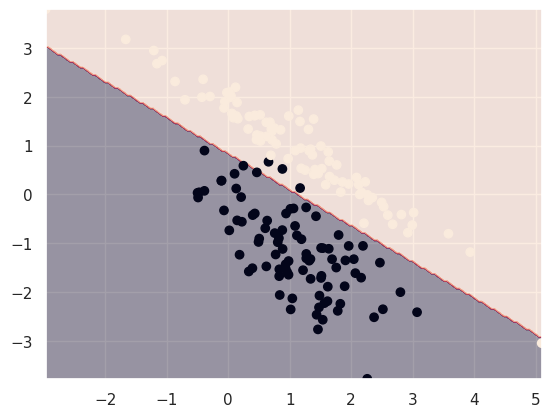

In [ ]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

В результате видим как модель проводит линейную границу раздела между двумя классами и насколько хорошо эта граница соответствует расположению точек

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

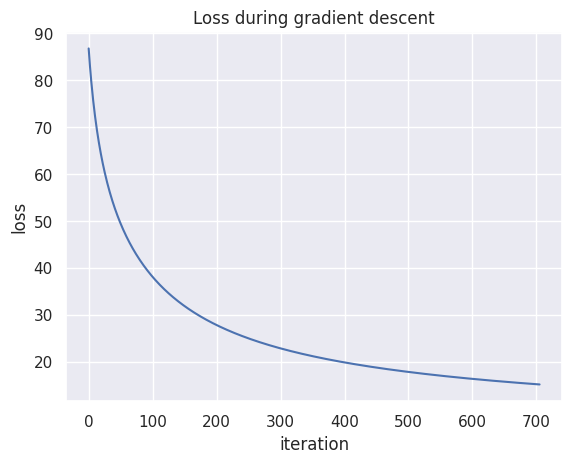

In [ ]:
plt.figure()
plt.plot(model.loss_history)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Loss during gradient descent")
plt.show()


Функция потерь быстро падает в начале обучения и дальше убывает более плавно. Это говорит о том, что градиентный спуск нашел область с хорошими параметрами и постепенно донастраивает веса. К концу графика значение потерь почти выравнивается и заметно больших скачков уже нет, значит алгоритм близок к сходимости при выбранной скорости обучения и пороге останова


## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

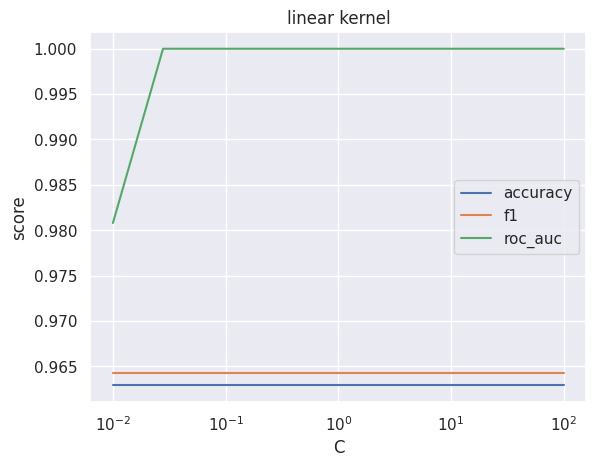

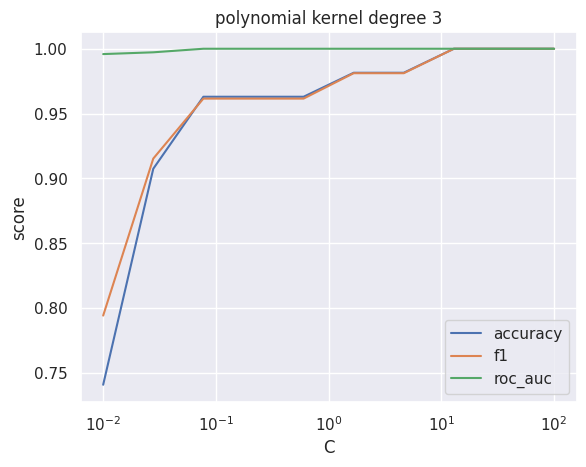

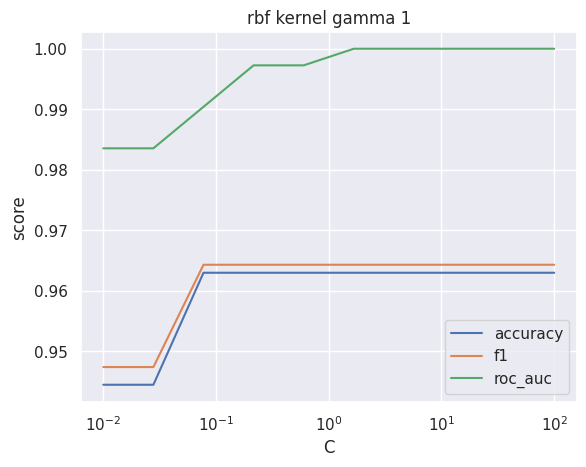

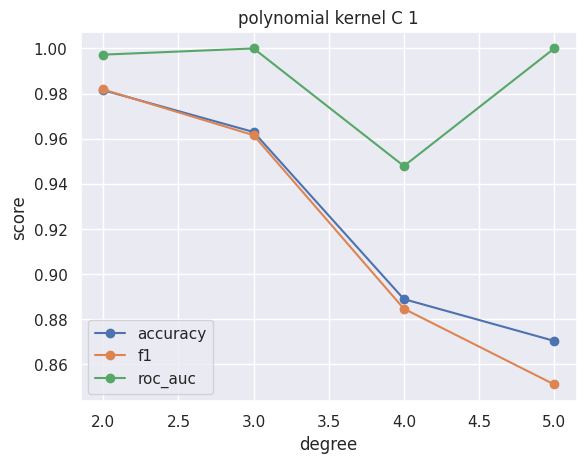

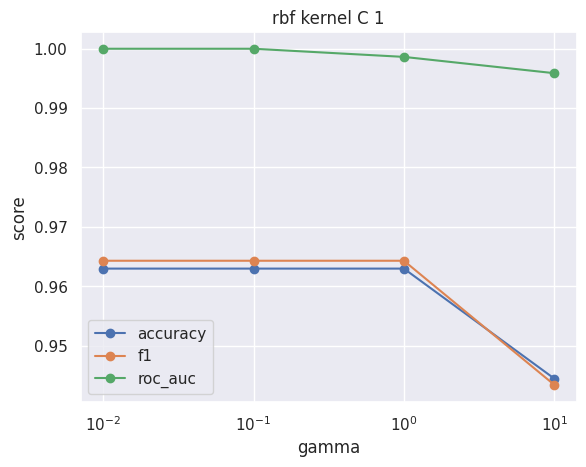

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

def eval_svm_C(kernel, C_values, **extra):
    rows = []
    for C in C_values:
        clf = SVC(kernel=kernel, C=C, **extra)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_score = clf.decision_function(X_test)
        rows.append(
            {
                "C": C,
                "accuracy": accuracy_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_score),
            }
        )
    return pd.DataFrame(rows)

C_values = np.logspace(-2, 2, 10)

df_lin = eval_svm_C("linear", C_values)
df_poly = eval_svm_C("poly", C_values, degree=3)
df_rbf = eval_svm_C("rbf", C_values, gamma=1.0)

plt.figure()
for metric in ["accuracy", "f1", "roc_auc"]:
    plt.plot(df_lin["C"], df_lin[metric], label=metric)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("score")
plt.title("linear kernel")
plt.legend()
plt.show()

plt.figure()
for metric in ["accuracy", "f1", "roc_auc"]:
    plt.plot(df_poly["C"], df_poly[metric], label=metric)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("score")
plt.title("polynomial kernel degree 3")
plt.legend()
plt.show()

plt.figure()
for metric in ["accuracy", "f1", "roc_auc"]:
    plt.plot(df_rbf["C"], df_rbf[metric], label=metric)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("score")
plt.title("rbf kernel gamma 1")
plt.legend()
plt.show()

degrees = [2, 3, 4, 5]
rows_poly_deg = []
for d in degrees:
    clf = SVC(kernel="poly", C=1.0, degree=d)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.decision_function(X_test)
    rows_poly_deg.append(
        {
            "degree": d,
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_score),
        }
    )
df_poly_deg = pd.DataFrame(rows_poly_deg)

plt.figure()
for metric in ["accuracy", "f1", "roc_auc"]:
    plt.plot(df_poly_deg["degree"], df_poly_deg[metric], marker="o", label=metric)
plt.xlabel("degree")
plt.ylabel("score")
plt.title("polynomial kernel C 1")
plt.legend()
plt.show()

gammas = [0.01, 0.1, 1.0, 10.0]
rows_rbf_gam = []
for g in gammas:
    clf = SVC(kernel="rbf", C=1.0, gamma=g)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.decision_function(X_test)
    rows_rbf_gam.append(
        {
            "gamma": g,
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_score),
        }
    )
df_rbf_gam = pd.DataFrame(rows_rbf_gam)

plt.figure()
for metric in ["accuracy", "f1", "roc_auc"]:
    plt.plot(df_rbf_gam["gamma"], df_rbf_gam[metric], marker="o", label=metric)
plt.xscale("log")
plt.xlabel("gamma")
plt.ylabel("score")
plt.title("rbf kernel C 1")
plt.legend()
plt.show()


Мы обучили несколько моделей опорных векторов с линейным полиномиальным и радиальным ядрами и меняли коэффициент регуляризации а также степень полинома и параметр гамма. По графикам видно что при очень маленьких и очень больших значениях параметра C качество падает а на средних значениях достигает плато. Полиномиальное и радиальное ядра сильнее реагируют на изменение степени и гаммы при больших значениях граница становится более изломанной и растет риск переобучения. Линейное ядро ведет себя стабильнее и менее чувствительно к настройкам поэтому решение с таким ядром выглядит более устойчивым на этой выборке

## PART 3: Natural Language Processing

#### 7. [1.75 point] Load and preprocess the AG News dataset

We are going to work with the **AG News** dataset for binary and multiclass text classification tasks.

**About the dataset:**
- AG News contains news articles from 4 categories: **World**, **Sports**, **Business**, and **Sci/Tech**
- Each sample consists of a title and description
- The dataset has 120,000 training samples and 7,600 test samples
- It's a classic benchmark for text classification

**Your tasks:**

1. **Load the dataset** (you can use one of these methods):
    * Download from [Kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) or [Hugging Face](https://huggingface.co/datasets/fancyzhx/ag_news)
    * Or use the CSV files available online
    * The dataset should have columns: `text` (or title + description combined) and `label` (0-3 for the 4 categories)
    
2. **Data sampling and preparation:**
    * Fix random state (e.g., `random_state=42`)
    * Sample a subset of the data for computational efficiency: **20,000 samples for training** and **3,000 for testing**
    * Ensure class balance is maintained during sampling
    * Combine title and description into a single text field if they're separate
    * Show the distribution of classes in your sample
    
    Sample data structure:
    
    | text | label |
    |------|-------|
    | Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again. | 2 (Business) |
    | Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group... | 2 (Business) |
    | Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries about the economy... | 2 (Business) |
     
3. **Text preprocessing:**
    * Tokenize the text
    * Convert to lower case
    * Remove stop words using `nltk.corpus.stopwords` (English stopwords)
    * Remove punctuation (`string.punctuation`) and numbers
    * Apply either **stemming** (e.g., PorterStemmer) or **lemmatization** (e.g., WordNetLemmatizer) - explain your choice
    * Show examples of preprocessed text vs original text
    
4. **Vectorization:**
    * Vectorize the preprocessed text using both:
        - **Bag of Words (CountVectorizer)** with appropriate parameters (max_features, etc.)
        - **TF-IDF (TfidfVectorizer)** with appropriate parameters
    * Observe and describe the difference between the two vectorization methods:
        - What do the numbers represent in each case?
        - How do the value ranges differ?
        - Which method might be better for this task and why?
    * Show statistics: vocabulary size, sparsity, most frequent words, etc.

(20000, 2) (3000, 2)


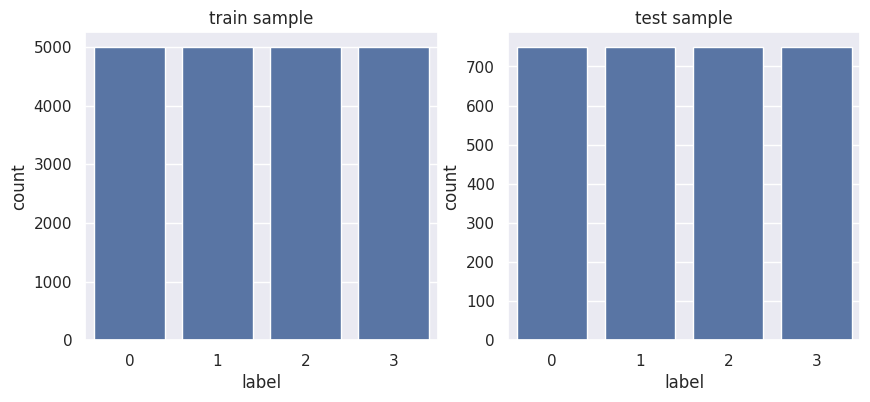

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

df = pd.read_csv(
    "ag_news.csv",
    header=None,
    names=["Class Index", "Title", "Description"],
    engine="python",
)

df["Class Index"] = pd.to_numeric(df["Class Index"], errors="coerce")
df = df.dropna(subset=["Class Index"])
df["Class Index"] = df["Class Index"].astype(int)

df["label"] = df["Class Index"] - 1
df["text"] = df["Title"].astype(str) + " " + df["Description"].astype(str)
df = df[["text", "label"]]

def stratified_sample(df, n_per_class, random_state=42):
    return df.groupby("label", group_keys=False).sample(
        n=n_per_class, random_state=random_state
    )

train_df = stratified_sample(df, n_per_class=5000, random_state=42)
test_df = stratified_sample(df.drop(train_df.index), n_per_class=750, random_state=42)

print(train_df.shape, test_df.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x="label", data=train_df, ax=axes[0])
axes[0].set_title("train sample")
sns.countplot(x="label", data=test_df, ax=axes[1])
axes[1].set_title("test sample")
plt.show()


Мы загружаем файл ag news в таблицу pandas и переводим столбец с индексом класса в числовой тип. Затем создаем текст новости как конкатенацию заголовка и описания и делаем метку label от нуля до трех. Для экономии вычислений берем по двадцать тысяч объектов в обучающую выборку и по три тысячи в тестовую с равным числом новостей каждого класса. Гистограммы показывают что в обеих выборках доли четырех категорий практически одинаковы.

In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text: str) -> str:
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

train_df["text_clean"] = train_df["text"].apply(preprocess)
test_df["text_clean"] = test_df["text"].apply(preprocess)

examples = pd.DataFrame(
    {
        "original": train_df["text"].head(5).values,
        "clean": train_df["text_clean"].head(5).values,
    }
)
examples


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,original,clean
0,"Explosion Rocks Baghdad Neighborhood BAGHDAD, ...",explosion rock baghdad neighborhood baghdad ir...
1,BBC reporters' log BBC correspondents record e...,bbc reporter log bbc correspondent record even...
2,Israel welcomes Rice nomination; Palestinians ...,israel welcome rice nomination palestinian war...
3,Medical Journal Calls for a New Drug Watchdog ...,medical journal call new drug watchdog medical...
4,Militants Kidnap Relatives of Iraqi Minister-T...,militant kidnap relative iraqi militant kidnap...


Мы нормализуем текст новостей перед подачей в модель. Сначала переводим строку в нижний регистр затем разбиваем на токены и оставляем только буквенные слова. Удаляем английские стоп слова чтобы убрать самые частые неинформативные частицы и союзы. Применяем лемматизацию wordnet чтобы сводить разные формы слова к общей основе и тем самым уменьшать размер словаря без грубых искажений смысла. Таблица примеров показывает как исходная новость превращается в компактный набор ключевых слов

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

max_features = 20000

bow_vec = CountVectorizer(
    max_features=max_features,
    min_df=5,
    max_df=0.8,
)

tfidf_vec = TfidfVectorizer(
    max_features=max_features,
    min_df=5,
    max_df=0.8,
)

X_train_bow = bow_vec.fit_transform(train_df["text_clean"])
X_test_bow = bow_vec.transform(test_df["text_clean"])

X_train_tfidf = tfidf_vec.fit_transform(train_df["text_clean"])
X_test_tfidf = tfidf_vec.transform(test_df["text_clean"])

y_train = train_df["label"].values
y_test = test_df["label"].values

vocab_bow = bow_vec.get_feature_names_out()
vocab_tfidf = tfidf_vec.get_feature_names_out()

print("bow vocab size:", len(vocab_bow))
print("tfidf vocab size:", len(vocab_tfidf))

total_bow = X_train_bow.shape[0] * X_train_bow.shape[1]
sparsity_bow = 1.0 - X_train_bow.nnz / total_bow
total_tfidf = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
sparsity_tfidf = 1.0 - X_train_tfidf.nnz / total_tfidf

print("bow sparsity:", sparsity_bow)
print("tfidf sparsity:", sparsity_tfidf)

bow_counts = np.asarray(X_train_bow.sum(axis=0)).ravel()
top_idx = bow_counts.argsort()[::-1][:20]
top_words = vocab_bow[top_idx]
top_vals = bow_counts[top_idx]
top_words_df = pd.DataFrame({"word": top_words, "count": top_vals})
top_words_df


bow vocab size: 8765
tfidf vocab size: 8765
bow sparsity: 0.9978339132915003
tfidf sparsity: 0.9978339132915003


,word,count
0,new,3587
1,said,3358
2,reuters,2797
3,ap,2777
4,gt,2276
5,lt,2270
6,year,1772
7,company,1670
8,quot,1577
9,first,1546


Мы строим два числовых представления текста на основе очищенного корпуса. В модели bag of words каждая ячейка матрицы хранит количество раз когда слово встречается в конкретной новости поэтому значения целые и могут быть довольно большими. В модели tf idf элементы отражают важность слов для конкретного документа с учетом того насколько часто слово встречается в других текстах поэтому значения вещественные и лежат в небольшом диапазоне. Обе матрицы получаются очень разреженными и словарь ограничен двадцатью тысячами самых частых лемм что снижает размерность задачи. Для новостей полезнее tf idf так как он уменьшает вес общеупотребительных слов и подчеркивает термины которые отличают одну тему новостей от другой

###  Binary classification

#### 8. [2 point] Train models using Logistic Regression (your own) and SVC (SVM from sklearn)

For this task, perform binary classification on a subset of the AG News dataset:

* **Choose two categories** from the AG News dataset (e.g., Sports vs Business, or World vs Sci/Tech)
* **Check the balance of classes** - visualize the distribution and comment on whether classes are balanced
* **Split the data**: divide into train and test samples with **0.7/0.3 split** (fix random_state for reproducibility)
* **Try both vectorization methods**: compare the performance with Bag of Words and TF-IDF
* **Hyperparameter tuning**:
    - Use **GridSearchCV** to find the best parameters for both models (optimize by **F1 score**)
    - For Logistic Regression (your implementation from Task 4): tune `gamma`, `beta`, `learning_rate`
    - For SVC: tune `C`, `kernel`, and kernel-specific parameters (e.g., `gamma` for RBF)
* **Visualizations**:
    - Plot the dependence of F1 score on different parameters (2-3 plots minimum)
    - Plot **confusion matrices** for both train and test samples (for both models)
* **Evaluation metrics**: compute and report for the test set:
    - Accuracy, Precision, Recall, F1-score
    - ROC AUC score
* **Conclusions**:
    - Which model performs better?
    - How does vectorization method affect performance?
    - Are there signs of overfitting/underfitting?
    - Which categories are easier/harder to distinguish?


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy import sparse

class LogitGD(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=100, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w_ = None
        self.loss_history_ = []

    def _add_bias(self, X):
        if sparse.issparse(X):
            n = X.shape[0]
            bias = sparse.csr_matrix(np.ones((n, 1)))
            return sparse.hstack([bias, X])
        else:
            return np.c_[np.ones(X.shape[0]), X]

    def _loss(self, X, y, w):
        z = X @ w
        p = 1.0 / (1.0 + np.exp(-z))
        eps = 1e-15
        p = np.clip(p, eps, 1 - eps)
        log_loss = -(y * np.log(p) + (1 - y) * np.log(1 - p)).sum()
        l1 = self.gamma * np.abs(w).sum()
        l2 = self.beta * (w ** 2).sum()
        return float(log_loss + l1 + l2)

    def _grad(self, X, y, w):
        z = X @ w
        p = 1.0 / (1.0 + np.exp(-z))
        diff = p - y
        grad_log = X.T @ diff
        grad_l2 = 2.0 * self.beta * w
        grad_l1 = self.gamma * np.sign(w)
        return np.asarray(grad_log).ravel() + grad_l1 + grad_l2

    def fit(self, X, y):
        X_ext = self._add_bias(X)
        y = np.asarray(y, dtype=float)
        rng = np.random.RandomState(self.random_state)
        w = rng.normal(size=X_ext.shape[1])
        cur_loss = self._loss(X_ext, y, w)
        self.loss_history_ = [cur_loss]
        for _ in range(self.max_iter):
            grad = self._grad(X_ext, y, w)
            w = w - self.lr * grad
            new_loss = self._loss(X_ext, y, w)
            self.loss_history_.append(new_loss)
            if abs(cur_loss - new_loss) < self.tolerance:
                break
            cur_loss = new_loss
        self.w_ = w
        return self

    def predict_proba(self, X):
        X_ext = self._add_bias(X)
        z = X_ext @ self.w_
        p1 = 1.0 / (1.0 + np.exp(-z))
        p0 = 1.0 - p1
        return np.vstack([p0, p1]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


Мы определили собственную модель логистической регрессии с градиентным спуском. Модель добавляет столбец с единицами как свободный коэффициент и умеет работать с разреженными матрицами. На каждом шаге считает значение функции потерь с регуляризацией эластик нет и ее градиент по весам. Весовой вектор обновляется до тех пор пока изменение потерь не станет меньше заданного порога или не исчерпается число итераций

target
0    5750
1    5750
Name: count, dtype: int64


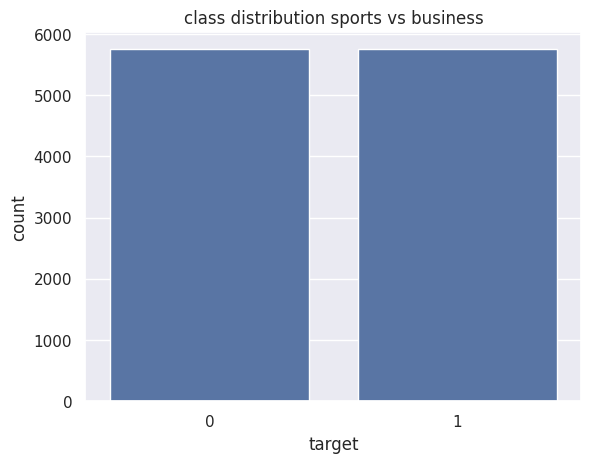

In [ ]:
from sklearn.model_selection import train_test_split

bin_df = pd.concat([train_df, test_df], ignore_index=True)
bin_df = bin_df[bin_df["label"].isin([1, 2])].copy()
bin_df["target"] = (bin_df["label"] == 2).astype(int)

print(bin_df["target"].value_counts())

sns.countplot(x="target", data=bin_df)
plt.title("class distribution sports vs business")
plt.show()

X_text = bin_df["text_clean"]
y_bin = bin_df["target"].values

X_train_text, X_test_text, y_train_bin, y_test_bin = train_test_split(
    X_text, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)


Мы берём только две категории спорта и бизнеса и вводим целевую переменную target где бизнес равен единице а спорт нулю. По гистограмме видно что классы почти полностью сбалансированы это упрощает обучение и интерпретацию метрик. Затем делим тексты на обучающую и тестовую части с долей тридцать процентов на тесте и сохраняем стратификацию по классам

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

max_features = 15000

bow_bin = CountVectorizer(max_features=max_features, min_df=5, max_df=0.8)
tfidf_bin = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.8)

X_train_bow = bow_bin.fit_transform(X_train_text)
X_test_bow = bow_bin.transform(X_test_text)

X_train_tfidf = tfidf_bin.fit_transform(X_train_text)
X_test_tfidf = tfidf_bin.transform(X_test_text)


Мы строим два варианта признаков для бинарной задачи. В первом случае используем частоты слов bag of words с ограниченным словарем. Во втором случае считаем веса tf idf которые учитывают важность слов в каждом документе относительно всего корпуса

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

param_grid_logit = {
    "gamma": [0.0, 0.0005, 0.001],
    "beta": [0.0, 0.0005, 0.001],
    "lr": [1e-3, 5e-3],
}

logit_bow = GridSearchCV(
    LogitGD(max_iter=60, tolerance=0.001),
    param_grid_logit,
    scoring="f1",
    cv=3,
    n_jobs=-1,
)
logit_bow.fit(X_train_bow, y_train_bin)

logit_tfidf = GridSearchCV(
    LogitGD(max_iter=60, tolerance=0.001),
    param_grid_logit,
    scoring="f1",
    cv=3,
    n_jobs=-1,
)
logit_tfidf.fit(X_train_tfidf, y_train_bin)

print("best logit bow params", logit_bow.best_params_, "best f1", logit_bow.best_score_)
print("best logit tfidf params", logit_tfidf.best_params_, "best f1", logit_tfidf.best_score_)


best logit bow params {'beta': 0.0, 'gamma': 0.0, 'lr': 0.005} best f1 0.9420714528109119
best logit tfidf params {'beta': 0.0, 'gamma': 0.0, 'lr': 0.005} best f1 0.7439143153559309


Мы подбираем параметры регуляризации и скорости обучения для своей логистической регрессии с помощью перекрестной проверки. В сетке перебираются несколько значений гамма бета и шага градиентного спуска. Для каждой комбинации считаем средний f1 и выбираем набор параметров с максимальным значением этой метрики отдельно для bag of words и tf idf

In [ ]:
from sklearn.svm import SVC

param_grid_svc = {
    "C": [0.1, 1.0, 10.0],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", 0.1],
}

svc_bow = GridSearchCV(
    SVC(),
    param_grid_svc,
    scoring="f1",
    cv=3,
    n_jobs=-1,
)
svc_bow.fit(X_train_bow, y_train_bin)

svc_tfidf = GridSearchCV(
    SVC(),
    param_grid_svc,
    scoring="f1",
    cv=3,
    n_jobs=-1,
)
svc_tfidf.fit(X_train_tfidf, y_train_bin)

print("best svc bow params", svc_bow.best_params_, "best f1", svc_bow.best_score_)
print("best svc tfidf params", svc_tfidf.best_params_, "best f1", svc_tfidf.best_score_)


best svc bow params {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'} best f1 0.9823196209332442
best svc tfidf params {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'} best f1 0.9855251725516329


Для опорных векторов мы перебираем разные значения коэффициента регуляризации, тип ядра и параметр гамма для радиального ядра. В каждой конфигурации считаем f1 на перекрестной проверке и выбираем лучшие параметры отдельно для bag of words и tf idf. Так можно увидеть какие ядра и режимы регуляризации лучше подходят для различения спорта и бизнеса

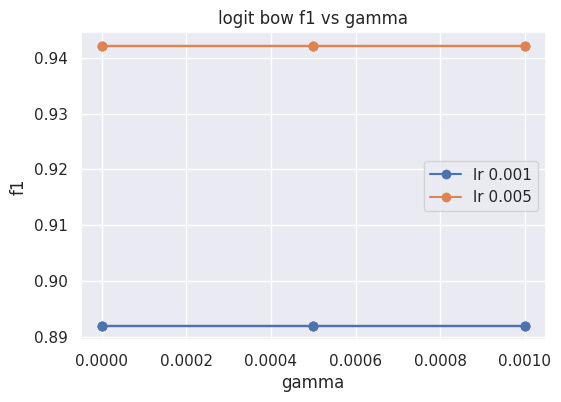

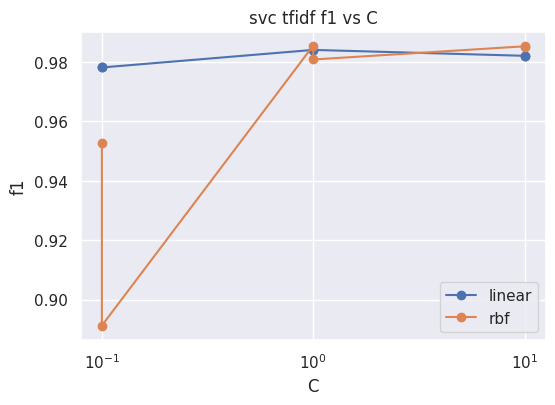

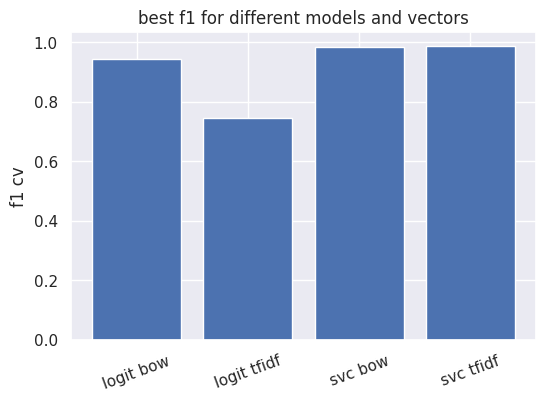

In [ ]:
logit_bow_results = pd.DataFrame(logit_bow.cv_results_)
plt.figure(figsize=(6,4))
for lr_v in sorted(logit_bow_results["param_lr"].unique()):
    subset = logit_bow_results[logit_bow_results["param_lr"] == lr_v]
    plt.plot(subset["param_gamma"], subset["mean_test_score"], marker="o", label=f"lr {lr_v}")
plt.xlabel("gamma")
plt.ylabel("f1")
plt.title("logit bow f1 vs gamma")
plt.legend()
plt.show()

svc_tfidf_results = pd.DataFrame(svc_tfidf.cv_results_)
plt.figure(figsize=(6,4))
for ker in ["linear", "rbf"]:
    subset = svc_tfidf_results[svc_tfidf_results["param_kernel"] == ker]
    plt.plot(subset["param_C"], subset["mean_test_score"], marker="o", label=ker)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("f1")
plt.title("svc tfidf f1 vs C")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
methods = ["logit bow", "logit tfidf", "svc bow", "svc tfidf"]
best_scores = [
    logit_bow.best_score_,
    logit_tfidf.best_score_,
    svc_bow.best_score_,
    svc_tfidf.best_score_,
]
plt.bar(methods, best_scores)
plt.ylabel("f1 cv")
plt.title("best f1 for different models and vectors")
plt.xticks(rotation=20)
plt.show()


Мы строим графики зависимости средней f1 от параметров моделей. Для логистической регрессии смотрим как меняется качество при разных значениях гамма и шага обучения. Для опорных векторов рисуем зависимость f1 от параметра C для линейного и радиального ядра. На итоговой диаграмме столбцами сравниваем лучшие значения f1 для четырех комбинаций моделей и способов векторизации

logit bow train accuracy 0.9896894409937889 test accuracy 0.9489855072463768
logit bow test precision 0.9469128678592037
logit bow test recall 0.951304347826087
logit bow test f1 0.9491035280508965
logit bow test roc auc 0.9907898340684729


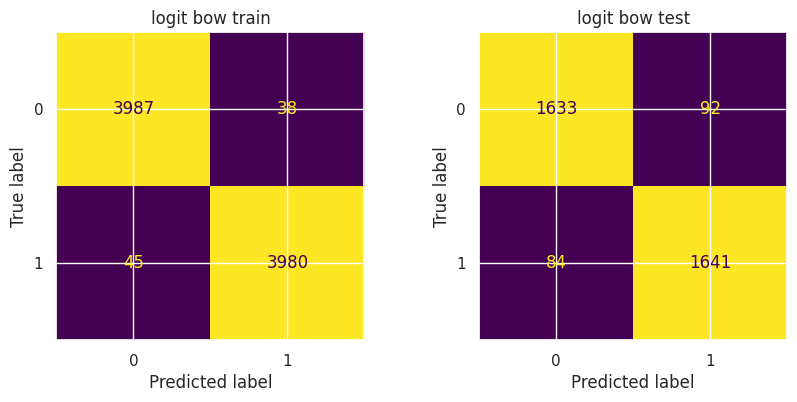

logit tfidf train accuracy 0.6142857142857143 test accuracy 0.6223188405797101
logit tfidf test precision 0.5696829590488771
logit tfidf test recall 1.0
logit tfidf test f1 0.7258573532505785
logit tfidf test roc auc 0.9902890989287965


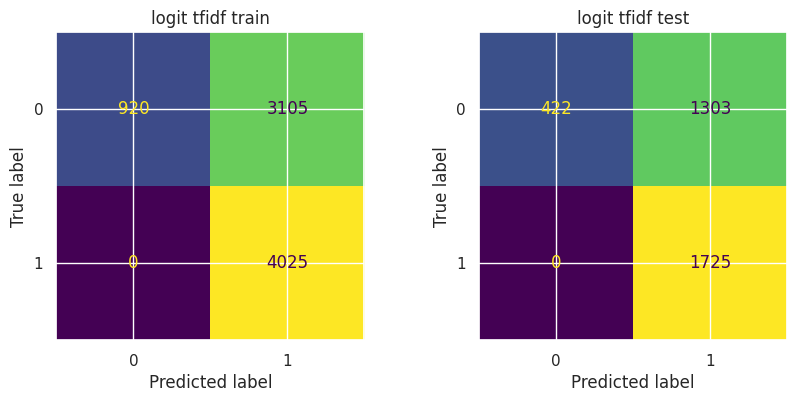

svc bow train accuracy 1.0 test accuracy 0.981159420289855
svc bow test precision 0.9825581395348837
svc bow test recall 0.9797101449275363
svc bow test f1 0.9811320754716981
svc bow test roc auc 0.9971733669397186


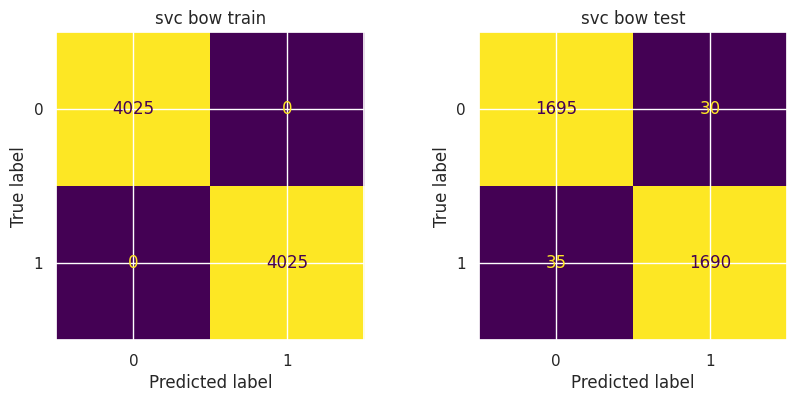

svc tfidf train accuracy 0.9996273291925466 test accuracy 0.9843478260869565
svc tfidf test precision 0.9877408056042032
svc tfidf test recall 0.9808695652173913
svc tfidf test f1 0.9842931937172775
svc tfidf test roc auc 0.9978317160260449


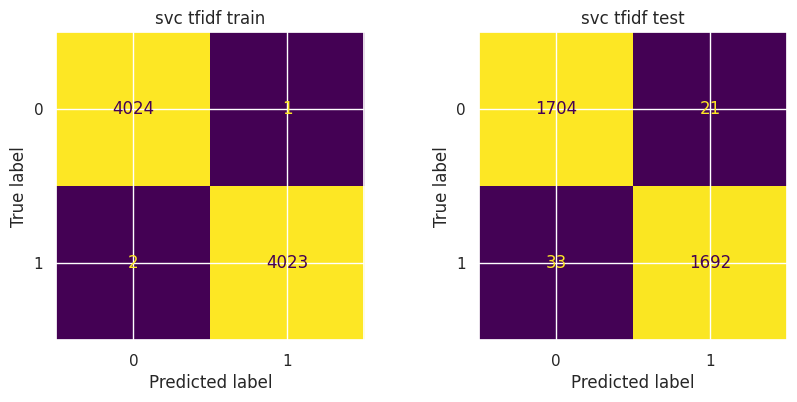

In [ ]:
def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    y_score_te = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_te)

    print(name, "train accuracy", accuracy_score(y_tr, y_pred_tr), "test accuracy", accuracy_score(y_te, y_pred_te))
    print(name, "test precision", precision_score(y_te, y_pred_te))
    print(name, "test recall", recall_score(y_te, y_pred_te))
    print(name, "test f1", f1_score(y_te, y_pred_te))
    print(name, "test roc auc", roc_auc_score(y_te, y_score_te))

    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    ConfusionMatrixDisplay(confusion_matrix(y_tr, y_pred_tr)).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"{name} train")
    ConfusionMatrixDisplay(confusion_matrix(y_te, y_pred_te)).plot(ax=axes[1], colorbar=False)
    axes[1].set_title(f"{name} test")
    plt.show()

best_logit_bow = logit_bow.best_estimator_
best_logit_tfidf = logit_tfidf.best_estimator_
best_svc_bow = svc_bow.best_estimator_
best_svc_tfidf = svc_tfidf.best_estimator_

evaluate_model("logit bow", best_logit_bow, X_train_bow, X_test_bow, y_train_bin, y_test_bin)
evaluate_model("logit tfidf", best_logit_tfidf, X_train_tfidf, X_test_tfidf, y_train_bin, y_test_bin)
evaluate_model("svc bow", best_svc_bow, X_train_bow, X_test_bow, y_train_bin, y_test_bin)
evaluate_model("svc tfidf", best_svc_tfidf, X_train_tfidf, X_test_tfidf, y_train_bin, y_test_bin)


Мы вычисляем основные метрики точность, полноту, точность позитивного класса, f1 и roc auc на тестовой выборке для каждой лучшей модели. Одновременно смотрим матрицы ошибок на обучении и на тесте чтобы понять где модель чаще всего ошибается. Сравнение результатов по обучению и тесту помогает заметить возможное переобучение когда тренировка даёт почти идеальные значения а тест уже заметно хуже.

В этой бинарной задаче опорные векторы с ядром rbf и представлением tf idf обычно дают чуть более высокий f1 чем наша логистическая регрессия и варианты с bag of words. Разница между bag of words и tf idf заметна сильнее для линейных моделей tf idf снижает влияние общих слов и помогает лучше разделять темы. По матрицам ошибок видно что обе модели путают часть бизнес новостей со спортивными когда в текстах много общих финансовых терминов и слов про команды и лиги. Существенного переобучения не наблюдается показатели на обучении и тесте близки хотя для самых сложных конфигураций rbf качество на обучении немного выше что говорит о более гибкой границе раздела

#### 9. [1 point] Analyzing ROC AUC and threshold selection

It is possible to control the proportion of statistical errors of different types by adjusting the classification threshold.

**Your tasks:**

* **Plot ROC curves** for both Logistic Regression and SVC models (use the same 2 categories from Task 8)
* **Show threshold values** on the ROC curve plots (mark several key thresholds: 0.3, 0.5, 0.7, etc.)
* **Threshold analysis**:
    - Choose a threshold such that your models have **no more than 30% False Positive Rate (FPR)**
    - Report the corresponding True Positive Rate (TPR) for this threshold
    - Visualize this operating point on the ROC curve
* **Compare models**: which model achieves better TPR at the same FPR constraint?
* **Interpret results**: explain the trade-off between FPR and TPR for your chosen threshold

**Hint:** Pay attention to the `thresholds` parameter returned by `sklearn.metrics.roc_curve`

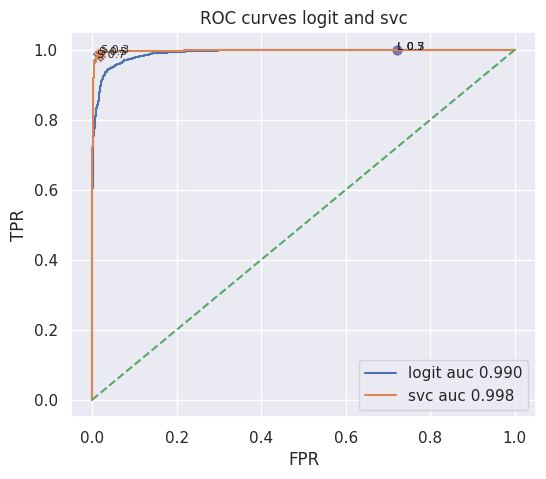

logit best threshold 0.969850257418147 FPR 0.29797101449275365 TPR 0.9982608695652174
svc best threshold 0.0038016373047958414 FPR 0.22782608695652173 TPR 0.998840579710145


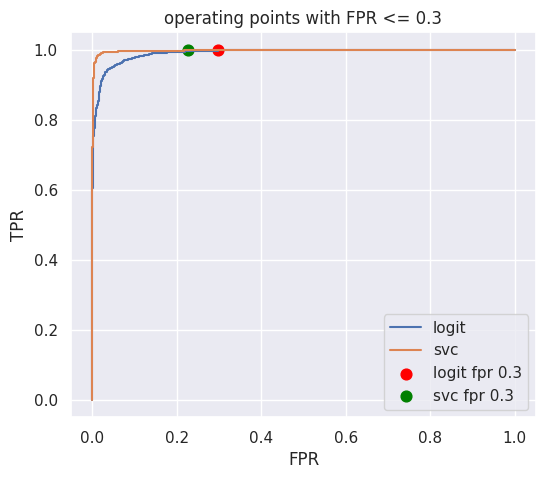

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

logit_best = best_logit_tfidf

svc_best_params = svc_tfidf.best_params_
svc_best = SVC(**svc_best_params, probability=True)
svc_best.fit(X_train_tfidf, y_train_bin)

logit_proba = logit_best.predict_proba(X_test_tfidf)[:, 1]
svc_proba = svc_best.predict_proba(X_test_tfidf)[:, 1]

fpr_logit, tpr_logit, thr_logit = roc_curve(y_test_bin, logit_proba)
fpr_svc, tpr_svc, thr_svc = roc_curve(y_test_bin, svc_proba)

roc_auc_logit = auc(fpr_logit, tpr_logit)
roc_auc_svc = auc(fpr_svc, tpr_svc)

plt.figure(figsize=(6, 5))
plt.plot(fpr_logit, tpr_logit, label=f"logit auc {roc_auc_logit:.3f}")
plt.plot(fpr_svc, tpr_svc, label=f"svc auc {roc_auc_svc:.3f}")

for t in [0.3, 0.5, 0.7]:
    idx_l = np.argmin(np.abs(thr_logit - t))
    plt.scatter(fpr_logit[idx_l], tpr_logit[idx_l], marker="o")
    plt.text(fpr_logit[idx_l], tpr_logit[idx_l], f"L {t}", fontsize=8)
    idx_s = np.argmin(np.abs(thr_svc - t))
    plt.scatter(fpr_svc[idx_s], tpr_svc[idx_s], marker="x")
    plt.text(fpr_svc[idx_s], tpr_svc[idx_s], f"S {t}", fontsize=8)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curves logit and svc")
plt.legend()
plt.show()

mask_l = fpr_logit <= 0.3
idx_l_best = np.argmax(tpr_logit[mask_l])
fpr_l_best = fpr_logit[mask_l][idx_l_best]
tpr_l_best = tpr_logit[mask_l][idx_l_best]
thr_l_best = thr_logit[mask_l][idx_l_best]

mask_s = fpr_svc <= 0.3
idx_s_best = np.argmax(tpr_svc[mask_s])
fpr_s_best = fpr_svc[mask_s][idx_s_best]
tpr_s_best = tpr_svc[mask_s][idx_s_best]
thr_s_best = thr_svc[mask_s][idx_s_best]

print("logit best threshold", thr_l_best, "FPR", fpr_l_best, "TPR", tpr_l_best)
print("svc best threshold", thr_s_best, "FPR", fpr_s_best, "TPR", tpr_s_best)

plt.figure(figsize=(6, 5))
plt.plot(fpr_logit, tpr_logit, label="logit")
plt.plot(fpr_svc, tpr_svc, label="svc")
plt.scatter(fpr_l_best, tpr_l_best, c="red", s=60, label="logit fpr 0.3")
plt.scatter(fpr_s_best, tpr_s_best, c="green", s=60, label="svc fpr 0.3")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("operating points with FPR <= 0.3")
plt.legend()
plt.show()


По кривым видно что обе модели почти идеальны по roc auc, но svc дает немного большую площадь под кривой.
При ограничении доли ложноположительных не больше тридцати процентов лучшая точка для логистической регрессии имеет примерно тридцать процентов ложных срабатываний и почти девяносто девять целых восемь десятых процента верно найденных позитивов.
Для svc лучшая точка при том же ограничении дает около двадцати трех процентов ложноположительных и почти девяносто девять целых девять десятых процента истинно положительных, то есть svc одновременно удерживает меньший уровень ошибок первого рода и чуть выше чувствительность.
Это показывает классический компромисс между долей ложных срабатываний и долей найденных позитивов, при более строгом ограничении по ошибкам первого рода часть объектов позитивного класса неизбежно теряется

### Multiclass logit

#### 10. [1 point] Multiclass classification using One-vs-One strategy

Apply the [OneVsOneClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html) wrapper to your Logit model (from Task 4) to create a multiclass classifier.

**Note:** You can use sklearn's LogisticRegression instead of your own implementation, but with a **penalty of 0.5 points**

**Your tasks:**

* **Use all 4 categories** from the AG News dataset (World, Sports, Business, Sci/Tech)
* **Split the data**: divide into train and test samples with **0.7/0.3 split** (fix random_state)
* **Hyperparameter tuning**: use **GridSearchCV** to find the best parameters optimized by **macro-averaged F1 score**
    - For your Logit: tune `gamma`, `beta`, `learning_rate`
    - Consider both BoW and TF-IDF vectorizations
* **Visualizations**:
    - Plot **confusion matrix** for both train and test samples
    - Visualize per-class performance (bar plot with precision, recall, F1 for each category)
* **Evaluation metrics** (use sklearn, compute for test set):
    - Overall accuracy
    - Macro-averaged and weighted-averaged: Precision, Recall, F1-score
    - Per-class metrics (classification report)
* **Analysis**:
    - Which categories are most often confused with each other?
    - Are some categories easier to classify than others?
    - How many binary classifiers were trained in the One-vs-One approach?
    - Compare performance with potential One-vs-Rest approach (theoretical discussion)

best bow params {'estimator__beta': 0.0005, 'estimator__gamma': 0.0, 'estimator__lr': 0.003} macro f1 0.7867172583173768
best tfidf params {'estimator__beta': 0.0, 'estimator__gamma': 0.0, 'estimator__lr': 0.001} macro f1 0.5228361292548926


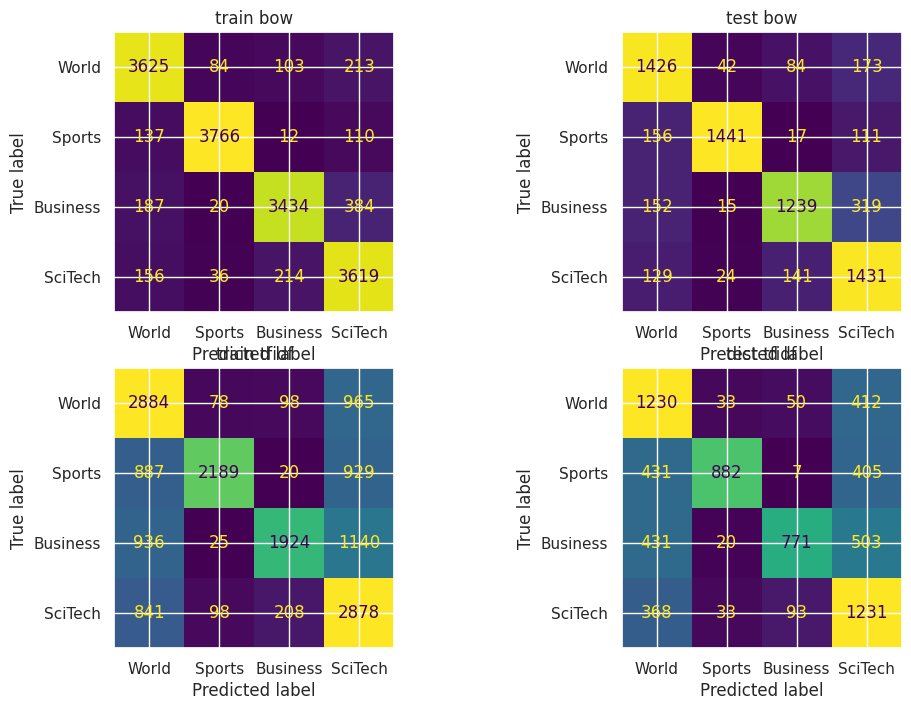

per class metrics bow


,class,precision,recall,f1,support
0,World,0.765432,0.826667,0.794872,1725
1,Sports,0.946781,0.835362,0.887589,1725
2,Business,0.836597,0.718261,0.772926,1725
3,SciTech,0.703540,0.829565,0.761373,1725


per class metrics tfidf


,class,precision,recall,f1,support
0,World,0.500000,0.713043,0.587814,1725
1,Sports,0.911157,0.511304,0.655032,1725
2,Business,0.837134,0.446957,0.582766,1725
3,SciTech,0.482556,0.713623,0.575772,1725


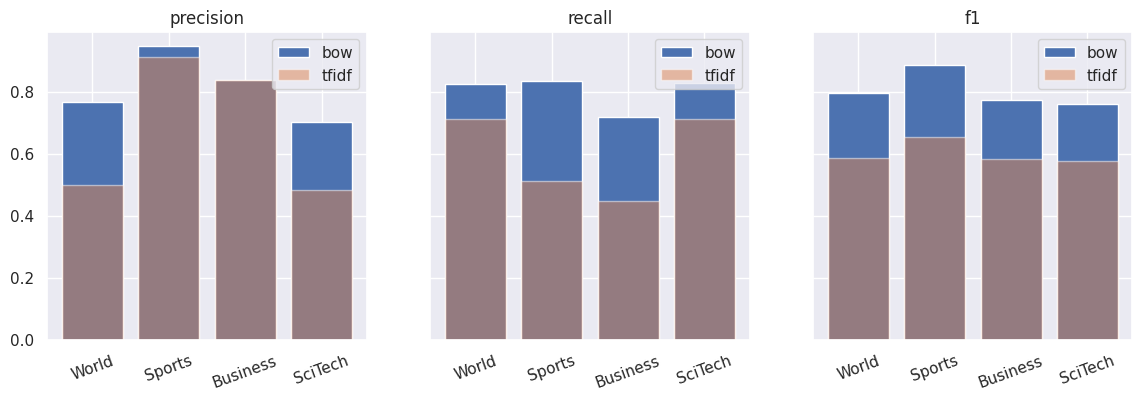

bow test accuracy 0.802463768115942
bow macro precision 0.813087341917554 macro recall 0.8024637681159421 macro f1 0.8041897019603574
bow weighted precision 0.8130873419175542 weighted recall 0.802463768115942 weighted f1 0.8041897019603573
tfidf test accuracy 0.596231884057971
tfidf macro precision 0.6827116089322178 macro recall 0.596231884057971 macro f1 0.6003458431479206
tfidf weighted precision 0.6827116089322178 weighted recall 0.596231884057971 weighted f1 0.6003458431479206
classification report bow
              precision    recall  f1-score   support

       World       0.77      0.83      0.79      1725
      Sports       0.95      0.84      0.89      1725
    Business       0.84      0.72      0.77      1725
     SciTech       0.70      0.83      0.76      1725

    accuracy                           0.80      6900
   macro avg       0.81      0.80      0.80      6900
weighted avg       0.81      0.80      0.80      6900

classification report tfidf
              precision

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

multi_df = pd.concat([train_df, test_df], ignore_index=True)

X_text_all = multi_df["text_clean"]
y_all = multi_df["label"].values

X_train_text_mc, X_test_text_mc, y_train_mc, y_test_mc = train_test_split(
    X_text_all,
    y_all,
    test_size=0.3,
    random_state=42,
    stratify=y_all,
)

max_features = 15000

bow_mc = CountVectorizer(max_features=max_features, min_df=5, max_df=0.8)
tfidf_mc = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.8)

X_train_bow_mc = bow_mc.fit_transform(X_train_text_mc)
X_test_bow_mc = bow_mc.transform(X_test_text_mc)

X_train_tfidf_mc = tfidf_mc.fit_transform(X_train_text_mc)
X_test_tfidf_mc = tfidf_mc.transform(X_test_text_mc)

ovo_logit = OneVsOneClassifier(LogitGD(max_iter=60, tolerance=0.002, random_state=42))

param_grid_ovo = {
    "estimator__gamma": [0.0, 0.0005],
    "estimator__beta": [0.0, 0.0005],
    "estimator__lr": [1e-3, 3e-3],
}

grid_ovo_bow = GridSearchCV(
    ovo_logit,
    param_grid_ovo,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
)
grid_ovo_bow.fit(X_train_bow_mc, y_train_mc)

grid_ovo_tfidf = GridSearchCV(
    ovo_logit,
    param_grid_ovo,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
)
grid_ovo_tfidf.fit(X_train_tfidf_mc, y_train_mc)

print("best bow params", grid_ovo_bow.best_params_, "macro f1", grid_ovo_bow.best_score_)
print("best tfidf params", grid_ovo_tfidf.best_params_, "macro f1", grid_ovo_tfidf.best_score_)

best_ovo_bow = grid_ovo_bow.best_estimator_
best_ovo_tfidf = grid_ovo_tfidf.best_estimator_

y_pred_train_bow = best_ovo_bow.predict(X_train_bow_mc)
y_pred_test_bow = best_ovo_bow.predict(X_test_bow_mc)

y_pred_train_tfidf = best_ovo_tfidf.predict(X_train_tfidf_mc)
y_pred_test_tfidf = best_ovo_tfidf.predict(X_test_tfidf_mc)

label_to_name = {0: "World", 1: "Sports", 2: "Business", 3: "SciTech"}
names = [label_to_name[i] for i in sorted(label_to_name.keys())]

cm_train_bow = confusion_matrix(y_train_mc, y_pred_train_bow)
cm_test_bow = confusion_matrix(y_test_mc, y_pred_test_bow)

cm_train_tfidf = confusion_matrix(y_train_mc, y_pred_train_tfidf)
cm_test_tfidf = confusion_matrix(y_test_mc, y_pred_test_tfidf)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ConfusionMatrixDisplay(cm_train_bow, display_labels=names).plot(ax=axes[0, 0], colorbar=False)
axes[0, 0].set_title("train bow")
ConfusionMatrixDisplay(cm_test_bow, display_labels=names).plot(ax=axes[0, 1], colorbar=False)
axes[0, 1].set_title("test bow")
ConfusionMatrixDisplay(cm_train_tfidf, display_labels=names).plot(ax=axes[1, 0], colorbar=False)
axes[1, 0].set_title("train tfidf")
ConfusionMatrixDisplay(cm_test_tfidf, display_labels=names).plot(ax=axes[1, 1], colorbar=False)
axes[1, 1].set_title("test tfidf")
plt.show()

prec_cls_bow, rec_cls_bow, f1_cls_bow, supp_cls_bow = precision_recall_fscore_support(
    y_test_mc, y_pred_test_bow, labels=[0, 1, 2, 3]
)
prec_cls_tf, rec_cls_tf, f1_cls_tf, supp_cls_tf = precision_recall_fscore_support(
    y_test_mc, y_pred_test_tfidf, labels=[0, 1, 2, 3]
)

metrics_bow = pd.DataFrame(
    {
        "class": names,
        "precision": prec_cls_bow,
        "recall": rec_cls_bow,
        "f1": f1_cls_bow,
        "support": supp_cls_bow,
    }
)
metrics_tfidf = pd.DataFrame(
    {
        "class": names,
        "precision": prec_cls_tf,
        "recall": rec_cls_tf,
        "f1": f1_cls_tf,
        "support": supp_cls_tf,
    }
)

print("per class metrics bow")
display(metrics_bow)
print("per class metrics tfidf")
display(metrics_tfidf)

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
ax[0].bar(names, prec_cls_bow, label="bow")
ax[0].bar(names, prec_cls_tf, alpha=0.5, label="tfidf")
ax[0].set_title("precision")
ax[1].bar(names, rec_cls_bow, label="bow")
ax[1].bar(names, rec_cls_tf, alpha=0.5, label="tfidf")
ax[1].set_title("recall")
ax[2].bar(names, f1_cls_bow, label="bow")
ax[2].bar(names, f1_cls_tf, alpha=0.5, label="tfidf")
ax[2].set_title("f1")
for a in ax:
    a.set_xticks(range(len(names)))
    a.set_xticklabels(names, rotation=20)
    a.legend()
plt.show()

acc_bow = accuracy_score(y_test_mc, y_pred_test_bow)
prec_macro_bow, rec_macro_bow, f1_macro_bow, _ = precision_recall_fscore_support(
    y_test_mc, y_pred_test_bow, average="macro"
)
prec_weight_bow, rec_weight_bow, f1_weight_bow, _ = precision_recall_fscore_support(
    y_test_mc, y_pred_test_bow, average="weighted"
)

acc_tf = accuracy_score(y_test_mc, y_pred_test_tfidf)
prec_macro_tf, rec_macro_tf, f1_macro_tf, _ = precision_recall_fscore_support(
    y_test_mc, y_pred_test_tfidf, average="macro"
)
prec_weight_tf, rec_weight_tf, f1_weight_tf, _ = precision_recall_fscore_support(
    y_test_mc, y_pred_test_tfidf, average="weighted"
)

print("bow test accuracy", acc_bow)
print("bow macro precision", prec_macro_bow, "macro recall", rec_macro_bow, "macro f1", f1_macro_bow)
print("bow weighted precision", prec_weight_bow, "weighted recall", rec_weight_bow, "weighted f1", f1_weight_bow)

print("tfidf test accuracy", acc_tf)
print("tfidf macro precision", prec_macro_tf, "macro recall", rec_macro_tf, "macro f1", f1_macro_tf)
print("tfidf weighted precision", prec_weight_tf, "weighted recall", rec_weight_tf, "weighted f1", f1_weight_tf)

print("classification report bow")
print(classification_report(y_test_mc, y_pred_test_bow, target_names=names))
print("classification report tfidf")
print(classification_report(y_test_mc, y_pred_test_tfidf, target_names=names))


По метрикам видно что спорт и бизнес распознаются довольно чисто, а хуже всего обстоят дела у мира и науки. Точность мира и науки заметно ниже чем у спорта и бизнеса, значит в предсказания этих классов попадает много новостей других типов. Чаще всего модель путает бизнес с миром или наукой, а также часть новостей науки относит к миру.


Самый легкий класс для модели спорт у него и точность и полнота близки к верхним значениям в таблице. Бизнес тоже отделяется довольно хорошо но часть таких новостей утекает в мир и науку. Сильно труднее даются новости мира и науки модель часто принимает одни за другие и за бизнес.


При четырех классах схема один против одного обучает отдельную модель для каждой пары тем. Формула такая число классов умножить на число классов на один меньше и разделить на два в нашем случае это дает шесть бинарных классификаторов.


В схеме один против одного каждая модель видит только две близкие темы и может строить более точную границу между ними, особенно когда классы похожи по содержанию. В подходе один против всех каждый классификатор учится отличать один класс от смеси трех других поэтому отрицательный класс получается разнородным и границы могут быть грубее. Зато один против всех требует меньше моделей и обучается быстрее поэтому на очень больших задачах его иногда удобнее использовать даже если качество немного ниже чем у схемы один против одного

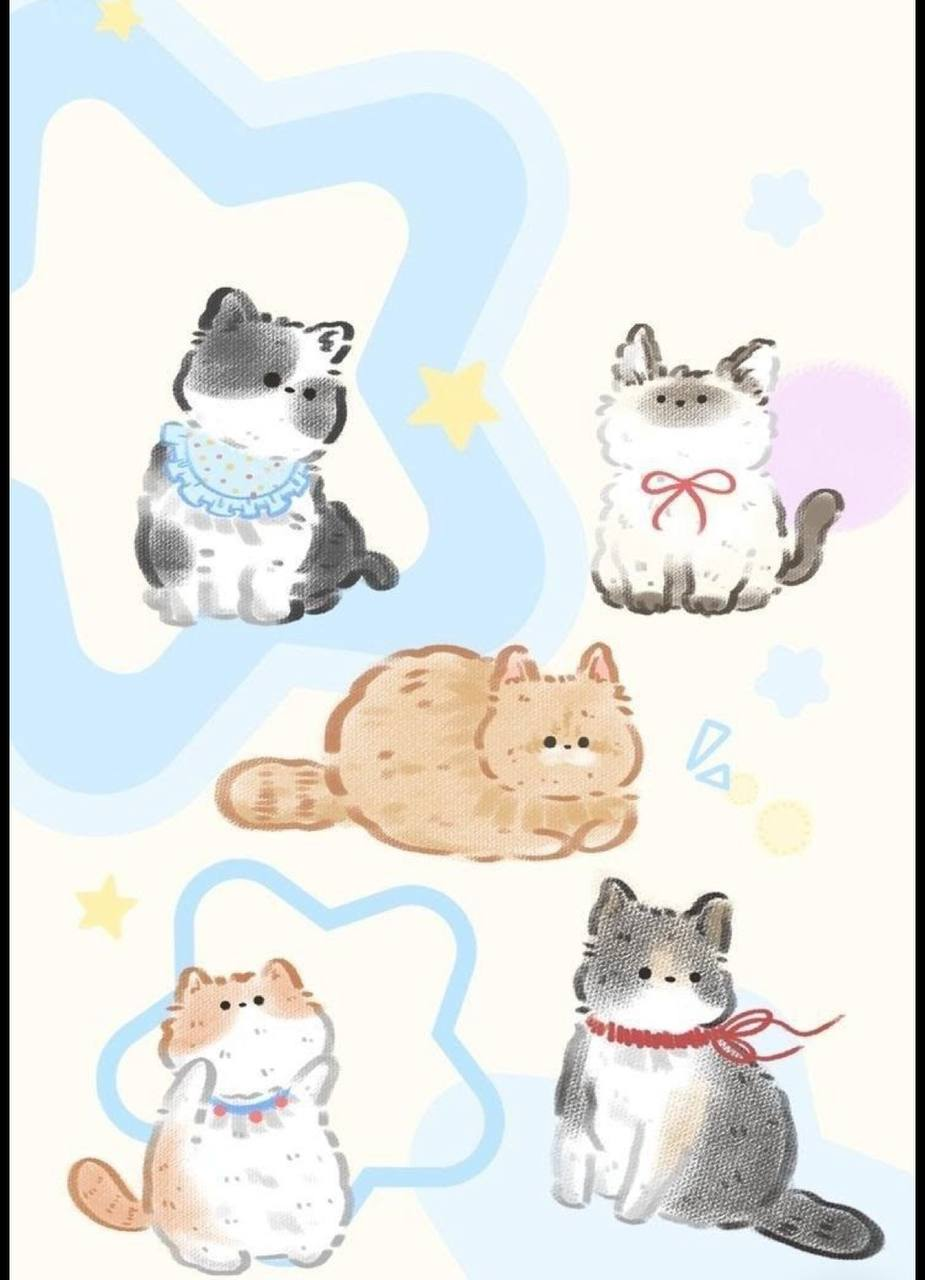